In [1]:
import numpy as np

alcohol_molecular_weight = {  # Unit: g/mol-1
    "water": 18.015,
    "1,2-ethanediol": 62.068,
    "1,2-propanediol": 	76.095,
    "1-butanol": 74.123,
    "1-propanol": 60.096,
    "2-propanol": 60.096,
    "propanol": 60.096,
    "IPA": 60.096,
    "isopropanol": 60.096,
    "teoa": 149.190,
    "ethanol": 46.069,
    "ether": 46.069,
    "ethyleneglycol": 62.068,
    "ethylene glycol": 62.068,
    "glycerol": 92.094,
    "glycol": 62.068,   # Should be checked. This is a group name not a alcohol name!!!
    "methanol": 32.04,
    "MeOH": 32.04,
    "propane-1,2,3-triol": 92.094,
    "propane-1,2-diol": 76.095,
    "propane-1,3-diol": 76.095,
    "propyleneglycol": 76.095,
    "tert-butanol": 74.123,
    "nan": np.NaN
}

In [2]:
alcohol_polarity = {  # Unit: g/mol-1
    "water": 1,
    "1,2-ethanediol": 0.79,
    "1,2-propanediol": -999,  # Wrong value
    "1-butanol": 0.586,
    "1-propanol": 0.617,
    "2-propanol": 0.546,
    "propanol": 0.617,
    "IPA": 0.546,
    "isopropanol": 0.546,
    "teoa": -999,  # Wrong value
    "ethanol": 0.654,
    "ether": 0.117,
    "ethyleneglycol": 0.79,
    "ethylene glycol": 0.79,
    "glycerol": 0.812,
    "glycol": 0.79,     # Propylene glycol
    "methanol": 0.762,
    "MeOH": 0.762,
    "propane-1,2,3-triol": 0.812,
    "propane-1,2-diol": -999,  # Wrong value
    "propane-1,3-diol": -999,  # Wrong value
    "propyleneglycol": -999,  # Wrong value
    "tert-butanol": 0.389,  # Wrong value
    "nan": np.NaN
}

alcohol_oh_number = {  # Unit: g/mol-1
    "water": 1,
    "1-butanol": 1,
    "1-propanol": 1,
    "propanol": 1,
    "2-propanol": 1,
    "teoa": 3,
    "ethanol": 1,
    "ether": 0,
    "ethylene glycol": 2,
    "glycerol": 3,
    "glycol": 2,      # Propylene glycol
    "methanol": 1,
    "propane-1,3-diol": 2,
    "propyleneglycol": 2,
    "tert-butanol": 1,
    "nan": np.NaN
}

alcohol_alpha_h = {  # Unit: g/mol-1
    "water": 1,
    "1-butanol": 2,
    "1-propanol": 2,
    "propanol": 2,
    "2-propanol": 1,
    "teoa": 6,
    "ethanol": 2,
    "ether": 0,
    "ethylene glycol": 4,
    "glycerol": 5,
    "glycol": 3,    # Propylene glycol
    "methanol": 3,
    "propane-1,3-diol": 4,
    "propyleneglycol": 3,
    "tert-butanol": 0,
    "nan": np.NaN
}

In [3]:
import os

import pandas as pd


from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sb

sb.set(style="white", font="Times New Roman", context="paper", palette='bright', font_scale=1.5)


%matplotlib inline

In [4]:
df = pd.read_excel("path to all data file", index_col="ID")

In [5]:

molecules_data = []
names_and_smiles = []

for file in os.listdir("structures"):
    with open(f"structures/{file}", "r") as f:
        data = f.readlines()        
        
        for line in data[4:]:
            
            structure_info = {}
            structure_info["mat_id"] = file.split(".")[0]
            structure_info["name"] = data[0].split("\n")[0]
            structure_info["smiles"] = data[1].split("\n")[0]
            structure_info["formula"] = data[3].split("\n")[0]
            
            line = line.split("\n")[0]

            structure_info["atom"] = line.split(" ")[0]
            structure_info["x"] = float(line.split(" ")[1])
            structure_info["y"] = float(line.split(" ")[2])
            structure_info["z"] = float(line.split(" ")[3])
            
            molecules_data.append(structure_info)

In [6]:
molecules_df = pd.DataFrame(molecules_data)

In [7]:

atomic_mass = {
    "H": 1.00797,
    "O": 15.9994,
    "C": 12.011,
    "N": 14.0067,
}


molecules_df["distance_to_global_center"] = 0
for name in molecules_df.name.unique().tolist():
    alcohol = molecules_df[molecules_df.name == name].copy()

    for structure in alcohol.smiles.unique().tolist():
        
        atoms = alcohol[alcohol.smiles == structure].atom.value_counts().index.tolist()
        
        x = 0; y = 0; z = 0;
        for atom in atoms:
            
            ff = alcohol[alcohol.smiles == structure][alcohol.atom == atom].copy()

            x += ff.x * atomic_mass[atom]
            y += ff.y * atomic_mass[atom]
            z += ff.z * atomic_mass[atom]

        center = np.array(
            [[
                np.sum(x) / alcohol_molecular_weight[name],
                np.sum(y) / alcohol_molecular_weight[name],
                np.sum(z) / alcohol_molecular_weight[name]
            ]]
        )
        
        distance_to_center = metrics.euclidean_distances(
            X=alcohol[alcohol.smiles == structure][["x", "y", "z"]].values,
            Y=center
        )

        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "distance_to_global_center"] =distance_to_center.reshape(-1, )




molecules_df["distance_to_carbon_center"] = 0
for name in molecules_df.name.unique().tolist():
    
    alcohol = molecules_df[molecules_df.name == name].copy()
    
    for structure in alcohol.smiles.unique().tolist():

        center = alcohol[alcohol.smiles == structure][alcohol.atom == "C"][["x", "y", "z"]].mean(axis=0).values.reshape(1, -1)

        if not name == "water":

            distance_to_center = metrics.euclidean_distances(
                X=alcohol[alcohol.smiles == structure][["x", "y", "z"]].values,
                Y=center
            ).reshape(-1, )
        else:
            distance_to_center = 0

        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "distance_to_carbon_center"] =distance_to_center
        

molecules_df["distance_to_closest_oxygen"] = 0
for name in molecules_df.name.unique().tolist():
    
    alcohol = molecules_df[molecules_df.name == name].copy()
    
    for structure in alcohol.smiles.unique().tolist():

        oxygens = alcohol[alcohol.smiles == structure][alcohol.atom == "O"][["x", "y", "z"]]
        
        distance_to_center = 100 * np.ones([alcohol[alcohol.smiles == structure][["x", "y", "z"]].shape[0], oxygens.shape[0] + 1])
        
        for i in range(len(oxygens)):
            
            distance_to_center[:, i] = metrics.euclidean_distances(
                X=alcohol[alcohol.smiles == structure][["x", "y", "z"]].values,
                Y=oxygens.iloc[[i]]
            ).reshape(-1, )

        distance_to_center = distance_to_center.min(axis=1).reshape(-1, )
        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "distance_to_closest_oxygen"] =distance_to_center

        

# This only calculate for hydrogens and rest of data are -999
molecules_df["valence_eletron_in_1_radius"] = -999
molecules_df["valence_eletron_in_2_radius"] = -999
molecules_df["valence_eletron_in_3_radius"] = -999
charges = {
    "C": 4,
    "O": 6,
    "N": 5,
    "H": 1,
}

for name in molecules_df.name.unique().tolist():
    alcohol = molecules_df[molecules_df.name == name].copy()
    
    for structure in alcohol.smiles.unique().tolist():
        
        distance_matrix = pd.DataFrame(
            data=metrics.euclidean_distances(alcohol[alcohol.smiles == structure][["x", "y", "z"]]),
            columns=alcohol[alcohol.smiles == structure].atom.values.tolist(),
            index=alcohol[alcohol.smiles == structure].atom.values.tolist(),
        )

        charge_in_1_radius = -999 * np.ones([distance_matrix.shape[0], 1])
        charge_in_2_radius = -999 * np.ones([distance_matrix.shape[0], 1])
        charge_in_3_radius = -999 * np.ones([distance_matrix.shape[0], 1])

        for index in range(distance_matrix.shape[0]):
            first_atom = distance_matrix.index.tolist()[index]
            
            neighbor_atoms_in_1_radius = []
            neighbor_atoms_in_2_radius = []
            neighbor_atoms_in_3_radius = []
            
            if first_atom == "H":
                for column in range(distance_matrix.shape[1]):
                    second_atom = distance_matrix.index.tolist()[column]
                    if distance_matrix.iloc[index][column] < 1:
                        neighbor_atoms_in_1_radius.append(second_atom)
                        
                    if distance_matrix.iloc[index][column] < 2:
                        neighbor_atoms_in_2_radius.append(second_atom)
                    
                    if distance_matrix.iloc[index][column] < 3:
                        neighbor_atoms_in_3_radius.append(second_atom)
                
                a, b, c = 0, 0, 0
                for i in neighbor_atoms_in_1_radius:
                    a += charges[i]
                for i in neighbor_atoms_in_2_radius:
                    b += charges[i]
                for i in neighbor_atoms_in_3_radius:
                    c += charges[i]
            
                charge_in_1_radius[index, 0] = a
                charge_in_2_radius[index, 0] = b
                charge_in_3_radius[index, 0] = c

        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "valence_eletron_in_1_radius"] =charge_in_1_radius
        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "valence_eletron_in_2_radius"] =charge_in_2_radius
        molecules_df.loc[alcohol[alcohol.smiles == structure].index.tolist(), "valence_eletron_in_3_radius"] =charge_in_3_radius




In [8]:
# Extract features from whole feature dataframe for each alcohol

structureal_features = []
for name in molecules_df.name.unique().tolist():

    alcohol = molecules_df[molecules_df.name == name].copy()
    
    for smiles in alcohol.smiles.unique().tolist():

        structureal_features.append(
            {
                "name": name,
                "smiles": smiles,
                "AMW": alcohol_molecular_weight[name], 
                "number_of_h": alcohol[alcohol.smiles == smiles].atom.value_counts()["H"], 
                "number_of_alpha_h": alcohol_alpha_h[name],
                "number_of_oh": alcohol_oh_number[name],
                "polarity": alcohol_polarity[name],
                
                "closest_h_to_global_center": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"].distance_to_global_center.min(),
                "closest_h_to_carbon_center": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"].distance_to_carbon_center.min(),
                "closest_h_to_oxygen": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"].distance_to_closest_oxygen.min(),
                "min_valence_eletron_in_1_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_1_radius != -999].valence_eletron_in_1_radius.min(),
                "min_valence_eletron_in_2_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_2_radius != -999].valence_eletron_in_2_radius.min(),
                "min_valence_eletron_in_3_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_3_radius != -999].valence_eletron_in_3_radius.min(),
                "max_valence_eletron_in_1_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_1_radius != -999].valence_eletron_in_1_radius.max(),
                "max_valence_eletron_in_2_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_2_radius != -999].valence_eletron_in_2_radius.max(),
                "max_valence_eletron_in_3_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_3_radius != -999].valence_eletron_in_3_radius.max(),
            }
        )

structureal_features = pd.DataFrame(structureal_features)

C:\Users\z5326694\AppData\Local\Temp/ipykernel_2388/472563298.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "min_valence_eletron_in_1_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_1_radius != -999].valence_eletron_in_1_radius.min(),
C:\Users\z5326694\AppData\Local\Temp/ipykernel_2388/472563298.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "min_valence_eletron_in_2_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_2_radius != -999].valence_eletron_in_2_radius.min(),
C:\Users\z5326694\AppData\Local\Temp/ipykernel_2388/472563298.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "min_valence_eletron_in_3_radius": alcohol[alcohol.smiles == smiles][alcohol.atom == "H"][alcohol.valence_eletron_in_3_radius != -999].valence_eletron_in_3_radius.min(),
C:\Users\z5326694\AppData\Local\Temp/ipykernel_23

In [9]:
# we dont have data for polarity of some alcohols so i delete them whci includes 1 sample


structureal_features = structureal_features[structureal_features.polarity != -999].copy()
structureal_features

,name,smiles,AMW,number_of_h,number_of_alpha_h,number_of_oh,polarity,closest_h_to_global_center,closest_h_to_carbon_center,closest_h_to_oxygen,min_valence_eletron_in_1_radius,min_valence_eletron_in_2_radius,min_valence_eletron_in_3_radius,max_valence_eletron_in_1_radius,max_valence_eletron_in_2_radius,max_valence_eletron_in_3_radius
0,water,O,18.015,2,1,1,1.000,0.902750,0.000000,0.968905,7.0,8.0,8.0,7.0,8.0,8.0
1,methanol,CO,32.040,4,3,1,0.762,1.381478,1.092597,0.968682,1.0,7.0,14.0,7.0,11.0,14.0
2,ethylene glycol,OCCO,62.068,6,4,2,0.790,1.592661,1.532420,0.970092,1.0,6.0,19.0,7.0,11.0,25.0
3,ethanol,OCC,46.069,6,2,1,0.654,1.500059,1.538009,0.969850,1.0,6.0,13.0,7.0,11.0,19.0
4,propanol,OC(C)C,60.096,8,2,1,0.617,1.468464,1.500435,0.971103,1.0,7.0,17.0,7.0,11.0,24.0
6,ether,COC,46.069,6,0,0,0.117,1.739877,1.653626,2.025739,1.0,7.0,13.0,1.0,7.0,18.0
7,2-propanol,CCOC,60.096,8,1,1,0.546,1.502351,1.372576,2.025751,1.0,6.0,13.0,1.0,7.0,23.0
8,1-propanol,CCCO,60.096,8,2,1,0.617,1.522844,1.505565,0.969134,1.0,6.0,13.0,7.0,11.0,23.0
9,1-butanol,CCCCO,74.123,10,2,1,0.586,1.329623,1.537354,0.969163,1.0,6.0,13.0,7.0,11.0,27.0
11,glycerol,OC(CO)CO,92.094,8,5,3,0.812,1.362562,1.500820,0.968511,1.0,5.0,13.0,7.0,11.0,35.0


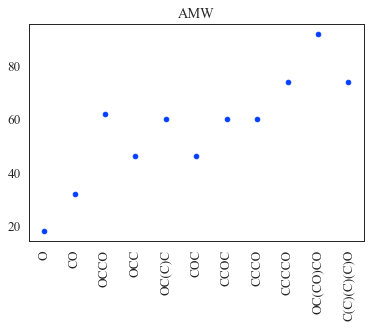

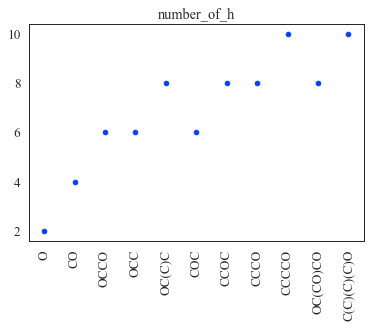

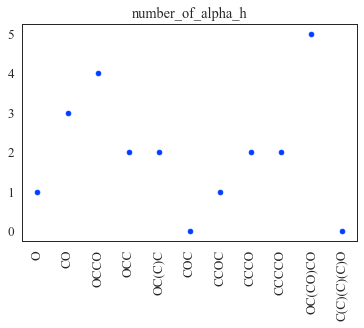

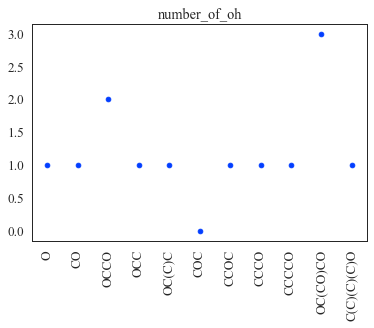

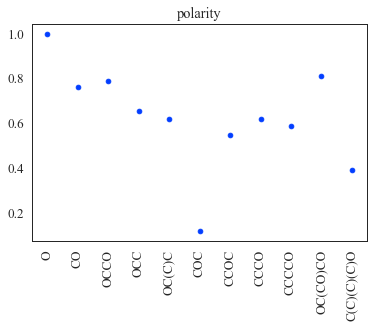

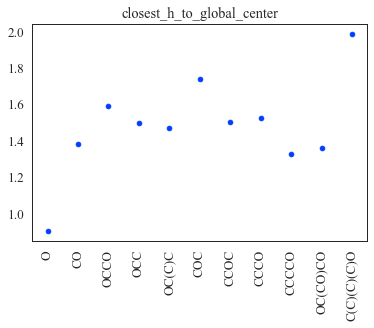

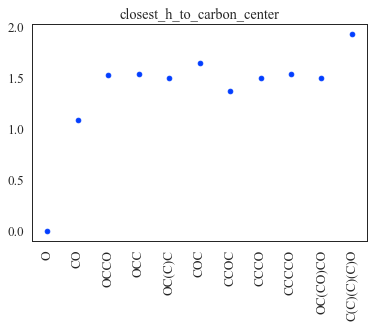

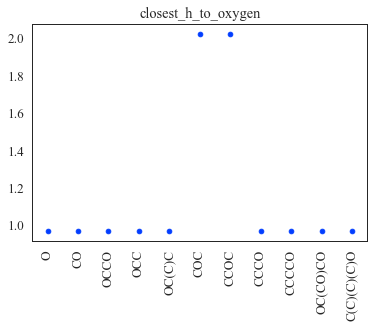

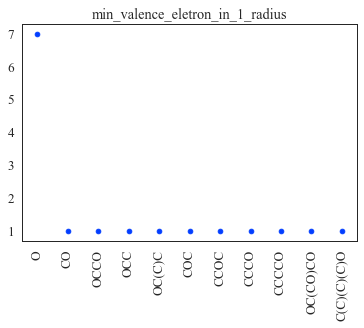

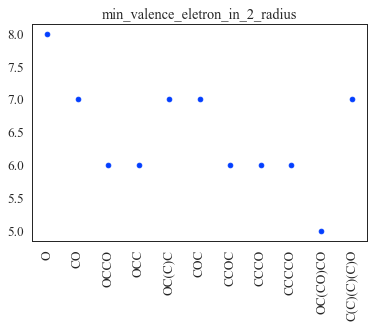

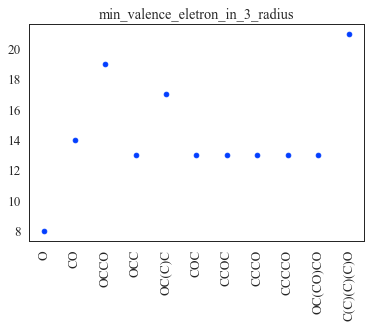

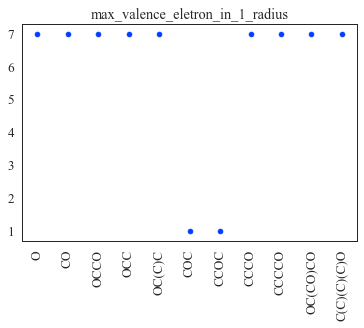

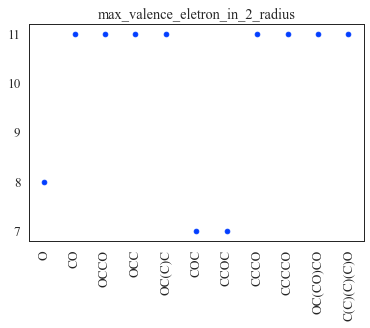

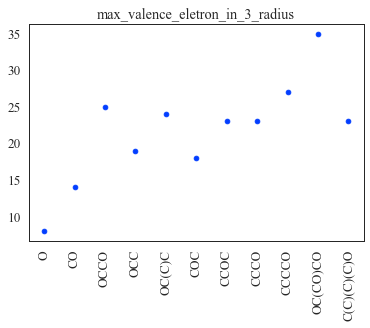

In [10]:

for i in structureal_features.columns.tolist()[2:]:
    
    plt.figure()
    plt.scatter(structureal_features.smiles, structureal_features[i])
    
    plt.title(i)
    plt.xticks(rotation=90)
    plt.show()

In [11]:
import numpy as np

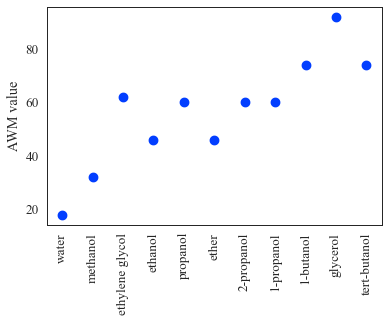

In [10]:
plt.figure()
plt.scatter(
    structureal_features.name, 
    structureal_features.AMW, 
    alpha=1, linewidths=5
)

# plt.title(i)
plt.xticks(rotation=90)
plt.ylabel("AWM value")
plt.savefig(f"AMW_feature.jpg", dpi=500, bbox_inches="tight")
plt.show()


engineered_feature = 5 * structureal_features.h_charge_with_highest_cahrge_in_2_radius.abs() + structureal_features.h_charge_with_lowest_cahrge_in_2_radius.abs() + structureal_features.number_of_o + structureal_features.closest_h_to_carbon_center.pow(2) * structureal_features.AMW / structureal_features.h_charge_with_highest_cahrge_in_3_radius.pow(2)

plt.figure()
plt.scatter(
    structureal_features.smiles, 
    engineered_feature,
    alpha=1, linewidths=5
)

# plt.title(i)
plt.xticks(rotation=90)
plt.ylabel("ATI value")
plt.savefig(f"ATI_feature.jpg", dpi=500, bbox_inches="tight")
plt.show()

In [14]:
# Use PCA to convert n-d to 1-d 

In [15]:
structureal_features.columns

Index(['name', 'smiles', 'AMW', 'number_of_h', 'number_of_alpha_h',
       'number_of_oh', 'polarity', 'closest_h_to_global_center',
       'closest_h_to_carbon_center', 'closest_h_to_oxygen',
       'min_valence_eletron_in_1_radius', 'min_valence_eletron_in_2_radius',
       'min_valence_eletron_in_3_radius', 'max_valence_eletron_in_1_radius',
       'max_valence_eletron_in_2_radius', 'max_valence_eletron_in_3_radius'],
      dtype='object')

In [11]:
features = [
    'AMW', 
    'number_of_h', 
    'number_of_alpha_h',
    'number_of_oh', 
    'polarity', 
    'closest_h_to_global_center',
    'closest_h_to_carbon_center', 
    'closest_h_to_oxygen',
    'min_valence_eletron_in_1_radius', 
    'min_valence_eletron_in_2_radius',
    'min_valence_eletron_in_3_radius', 
    'max_valence_eletron_in_1_radius',
    'max_valence_eletron_in_2_radius', 
    'max_valence_eletron_in_3_radius'
]

In [12]:
structureal_features = structureal_features[structureal_features.name != "propanol"].copy()

In [13]:
# normalization of data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(structureal_features[features])

normalized_structural_features = pd.DataFrame(
    data=scaler.transform(structureal_features[features]),
    columns=features
)

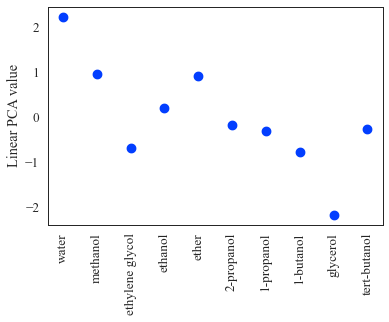

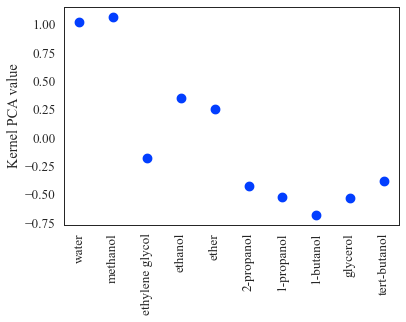

In [29]:
converted_features = [
    'AMW', 
    'number_of_h', 
    'number_of_alpha_h',
    'number_of_oh', 
    'polarity', 
    'closest_h_to_global_center',
    # 'closest_h_to_carbon_center', 
    # 'closest_h_to_oxygen',
    # 'min_valence_eletron_in_1_radius', 
    'min_valence_eletron_in_2_radius',
    # 'min_valence_eletron_in_3_radius', 
    # 'max_valence_eletron_in_1_radius',
    # 'max_valence_eletron_in_2_radius', 
    'max_valence_eletron_in_3_radius'
]


from sklearn.decomposition import PCA, KernelPCA

my_pca = PCA(n_components=1, random_state=14)

my_pca.fit(
    normalized_structural_features[converted_features]
)

plt.figure()
plt.scatter(
    structureal_features.name, 
    my_pca.transform(normalized_structural_features[converted_features]),
    alpha=1, linewidths=5
)



plt.xticks(rotation=90)
plt.ylabel("Linear PCA value")
plt.savefig(f"linear_PCA_converted_features.jpg", dpi=500, bbox_inches="tight")
plt.show()


# Kernel PCA =====================================================
'linear', 'poly',             'rbf', 'sigmoid', 'cosine'
kernel_pca = KernelPCA(n_components=1, kernel='cosine', degree=3, random_state=14)
kernel_pca.fit(
    normalized_structural_features[converted_features]
)

plt.figure()
plt.scatter(
    structureal_features.name, 
    kernel_pca.transform(normalized_structural_features[converted_features]),
    alpha=1, linewidths=5
)

plt.xticks(rotation=90)
plt.ylabel("Kernel PCA value")
plt.savefig(f"kernel_PCA_converted_features.jpg", dpi=500, bbox_inches="tight")
plt.show()





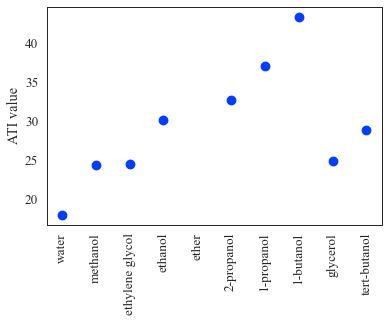

In [27]:
engineered_feature = (structureal_features.polarity * structureal_features.AMW)/(structureal_features.number_of_oh)

plt.figure()
plt.scatter(
    structureal_features.name, 
    engineered_feature,
    alpha=1, linewidths=5
)

# plt.title(i)
plt.xticks(rotation=90)
plt.ylabel("ATI value")
plt.savefig(f"engineered_feature_2.jpg", dpi=500, bbox_inches="tight")
plt.show()